# TRIMOD + Python: runner, Bayes layer, and sweep

Questo notebook contiene tutto il necessario per:
1) **Pilotare TRIMOD** (Fortran) da Python (`runner.py`),
2) definire **prior, likelihood e posterior** (`bayes_trimod.py`),
3) eseguire uno **sweep 1D** su un parametro e salvare i risultati (`sweep.py`).

Funziona sia in Jupyter sia da terminale. Se esegui in WSL/Ubuntu senza GUI, i grafici vengono **salvati** su file.

## Requisiti
- Ubuntu/WSL con `gfortran`, `make`, e `libopenblas-dev`.
- TRIMOD **compilato** in un eseguibile Linux (es. `./run`) nella stessa cartella di questo notebook.
- Python 3.10+ con `numpy`, `scipy`, `matplotlib`, `pandas`.


## Percorsi
Imposta il percorso dell'eseguibile Fortran e la cartella di lavoro.

In [ ]:
from pathlib import Path
TRIMOD_EXE = Path('./run')        #path dell'eseguibile fortran 
WORKDIR    = Path('./WORK')       #workdir dove verranno scritti/lettti i file
WORKDIR.mkdir(exist_ok=True)
TRIMOD_EXE

PosixPath('run')

## `runner.py`
Wrapper robusto per eseguire TRIMOD da Python, scrivere `params.in` e leggere `output.dat`. 

In [ ]:
from __future__ import annotations
import os, re, subprocess
from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, Optional, Tuple

_RE_E = re.compile(r"""3-body\s+binding\s+energy\s*=\s*([-+]?[\d.]+(?:[eE][-+]?\d+)?)\s*MeV""" )

@dataclass
class TrimodRunner:
    exe: str | os.PathLike = './run'
    workdir: str | os.PathLike = './WORK'

    def __post_init__(self):
        # 1)risolvi percorso eseguibile in assoluto, così da poter cambiare se necessario cartella di lavoro senza perdere l'eseguibile
        self.exe_path = Path(self.exe).resolve()
        # 2)workdir: converte wordir in un oggetto Path
        self.workdir = Path(self.workdir)
        self.workdir.mkdir(parents=True, exist_ok=True)
        # 3)fallback, se non troba l'eseguibile prima controlla './fortran/run' 
        if not self.exe_path.exists():
            alt = Path('./fortran/run').resolve()
            if alt.exists():
                self.exe_path = alt
        # 4)check: ultimo controllo, se ancora non c'è si ferma qui
        if not self.exe_path.exists():
            raise FileNotFoundError(f'TRIMOD executable not found: {self.exe}')
        # 5)assicura bit eseguibile 
        try:
            self.exe_path.chmod(self.exe_path.stat().st_mode | 0o111)
        except Exception:
            pass

    def write_params(self, theta: Iterable[float]) -> Path:  #questa funzione scrive i parametri in un file di testo
        v01, v02, a1, a2 = map(float, tuple(theta))
        p = self.workdir / 'params.in'
        p.write_text(f"{v01:.12g} {v02:.12g} {a1:.12g} {a2:.12g}\n", encoding='utf-8')
        return p


    def _clean_output(self) -> None:
        for name in ('output.dat', 'stdout.txt', 'stderr.txt'):
            f = self.workdir / name
            if f.exists():
                try: f.unlink()
                except Exception: pass

    @staticmethod
    def _parse_energy(text: str):
        m = _RE_E.search(text)
        return float(m.group(1)) if m else None

    def run_once(self):
        self._clean_output()
        proc = subprocess.run([str(self.exe_path)], cwd=str(self.workdir),
                              capture_output=True, text=True)
        (self.workdir/'stdout.txt').write_text(proc.stdout or '', encoding='utf-8')
        (self.workdir/'stderr.txt').write_text(proc.stderr or '', encoding='utf-8')

        out_text = ''
        out_file = self.workdir / 'output.dat'
        if out_file.exists():
            try: out_text = out_file.read_text(encoding='utf-8', errors='ignore')
            except Exception: out_text = out_file.read_bytes().decode('utf-8', errors='ignore')

        combined = (proc.stdout or '') + '\n' + (proc.stderr or '') + '\n' + out_text
        lowered = combined.lower()
        nonconv = any(k in lowered for k in ['too many iterations','itermax','iemax','not converg'])
        E3 = self._parse_energy(out_text)
        if E3 is None or nonconv:
            return (None, combined)
        return (E3, combined)

    def run_one(self, theta: Iterable[float]) -> float:
        self.write_params(theta)
        E3, log = self.run_once()
        if E3 is None:
            last = "\n".join((log or '').splitlines()[-25:])
            raise RuntimeError('TRIMOD not converged or energy not found.\n--- tail ---\n' + last)
        return E3


### Test rapido del runner

In [22]:
from math import isnan
tr = TrimodRunner(exe=str(TRIMOD_EXE), workdir=str(WORKDIR))
theta_test = (-50.0, -30.0, 1.5, 2.0)
try:
    E3 = tr.run_one(theta_test)
    print('E3 =', E3, 'MeV')
except Exception as e:
    print(e)


E3 = -7.540551 MeV


## `bayes_trimod.py`
Definizione di prior, likelihood e posterior + funzione di sweep 1D.

In [ ]:
import math, numpy as np
from typing import Iterable, Tuple, List, Dict
from dataclasses import dataclass
from runner import TrimodRunner
import numpy as np

def logsumexp(a):
    a = np.asarray(a, dtype=float)
    m = np.nanmax(a)
    if not np.isfinite(m):
        return -np.inf
    return m + np.log(np.nansum(np.exp(a - m)))

E3_EXP   = -8.482
SIGMA_TH = 0.5
SIGMA_EXP= 0.001
SIGMA    = math.hypot(SIGMA_TH, SIGMA_EXP)

PRIOR_RANGES = {
    'v01': (-200.0, -1.0),
    'v02': (-200.0, -1.0),
    'a1' : (0.2, 5.0),
    'a2' : (0.2, 5.0),
}

def logprior(theta: Iterable[float]) -> float:
    v01,v02,a1,a2 = theta
    if not(PRIOR_RANGES['v01'][0] <= v01 <= PRIOR_RANGES['v01'][1]): return -math.inf
    if not(PRIOR_RANGES['v02'][0] <= v02 <= PRIOR_RANGES['v02'][1]): return -math.inf
    if not(PRIOR_RANGES['a1'][0]  <= a1  <= PRIOR_RANGES['a1'][1]):  return -math.inf
    if not(PRIOR_RANGES['a2'][0]  <= a2  <= PRIOR_RANGES['a2'][1]):  return -math.inf
    return 0.0

def loglike(theta: Iterable[float], tr: TrimodRunner) -> float:
    E3 = tr.run_one(theta)
    r  = (E3 - E3_EXP) / SIGMA
    return -0.5 * (r*r) - math.log(SIGMA * math.sqrt(2.0*math.pi))

def logposterior(theta: Iterable[float], tr: TrimodRunner) -> float:
    lp = logprior(theta)
    if not np.isfinite(lp): return -math.inf
    try: return lp + loglike(theta, tr)
    except Exception: return -math.inf

def sweep1d(param: str, pmin: float, pmax: float, n: int,
            theta_fixed: Tuple[float,float,float,float],
            tr: TrimodRunner):
    idx = {'v01':0,'v02':1,'a1':2,'a2':3}[param]
    grid = np.linspace(pmin, pmax, n)
    rows = []
    for val in grid:
        theta = list(theta_fixed); theta[idx] = float(val)
        lp = logposterior(theta, tr)
        if np.isfinite(lp):
            try: E3 = tr.run_one(theta)
            except Exception: E3 = float('nan')
        else:
            E3 = float('nan')
        rows.append({'x': float(val), 'E3': E3, 'logpost': float(lp)})
    logw = np.array([r['logpost'] for r in rows], float)
    mask = np.isfinite(logw)
    if mask.any():
        logw_norm = logw.copy()
        logw_norm[mask] -= logsumexp(logw[mask])
        w = np.exp(logw_norm)
    else:
        w = np.zeros_like(logw)
    for r, wi in zip(rows, w): r['post_norm'] = float(wi)
    return rows


### Valutazione del log-posterior per un punto θ

In [24]:
th = (-50.0, -30.0, 1.5, 2.0)
tr = TrimodRunner(exe=str(TRIMOD_EXE), workdir=str(WORKDIR))
lp = logposterior(th, tr)
print('logposterior(theta) =', lp)

logposterior(theta) = -1.998438701261331


## `sweep.py` (sweep 1D e salvataggio CSV)

In [ ]:
import importlib, bayes_trimod
importlib.reload(bayes_trimod)

from bayes_trimod import sweep1d  


In [ ]:
import csv
from pathlib import Path
import matplotlib
matplotlib.use('Agg')  #backend non-interattivo
import matplotlib.pyplot as plt

from runner import TrimodRunner
from bayes_trimod import sweep1d

TRIMOD_EXE = './run'
WORKDIR    = './WORK'

def main():
    tr = TrimodRunner(exe=TRIMOD_EXE, workdir=WORKDIR)
    # Sweep su v01 con altri parametri fissi
    rows = sweep1d(param='v01', pmin=-120, pmax=-20, n=12,
                   theta_fixed=(-50.0, -30.0, 1.5, 2.0), tr=tr)
    # Salva CSV
    out_csv = Path('sweep_v01.csv')
    with out_csv.open('w', newline='') as f:
        w = csv.DictWriter(f, fieldnames=['param','x','E3','logpost','post_norm'])
        w.writeheader(); w.writerows(rows)
    print('Saved', len(rows), 'rows to', out_csv)

    # Grafici salvati su file
    xs   = [r['x'] for r in rows]
    E3s  = [r['E3'] for r in rows]
    post = [r['post_norm'] for r in rows]

    Path('figs').mkdir(exist_ok=True)

    plt.figure(figsize=(6,4))
    plt.plot(xs, E3s, marker='o')
    plt.axhline(-8.482, ls='--', label='E3 exp')
    plt.xlabel('v01'); plt.ylabel('E3 [MeV]'); plt.grid(True); plt.legend(); plt.tight_layout()
    plt.savefig('figs/E3_vs_v01.png', dpi=200)

    plt.figure(figsize=(6,4))
    plt.plot(xs, post, marker='o')
    plt.xlabel('v01'); plt.ylabel('Posterior (norm)'); plt.grid(True); plt.tight_layout()
    plt.savefig('figs/post_vs_v01.png', dpi=200)

if __name__ == '__main__':
    main()


Saved 12 rows to sweep_v01.csv


### Esempio: plot


backend: inline
Letti 12 punti da sweep_v01.csv
  param           x        E3   logpost  post_norm
0   v01 -120.000000 -7.540551 -1.998439   0.083333
1   v01 -110.909091 -7.540551 -1.998439   0.083333
2   v01 -101.818182 -7.540551 -1.998439   0.083333
3   v01  -92.727273 -7.540551 -1.998439   0.083333
4   v01  -83.636364 -7.540551 -1.998439   0.083333


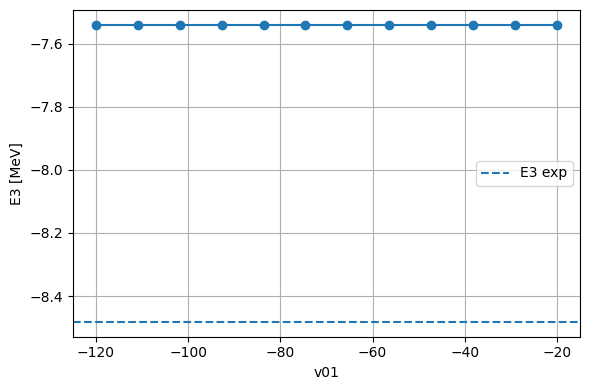

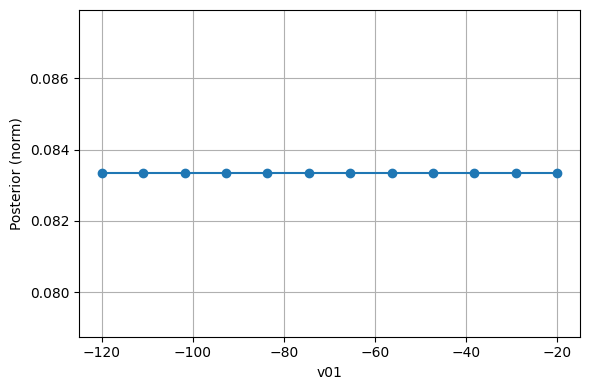

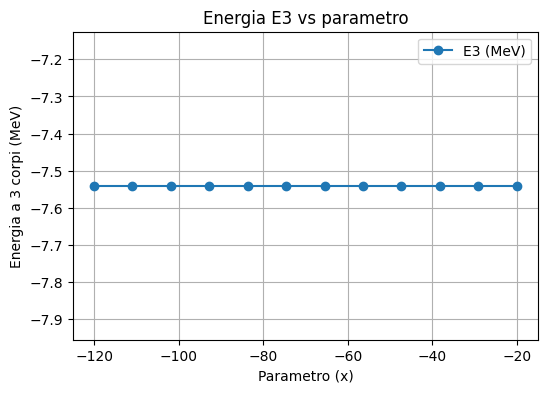

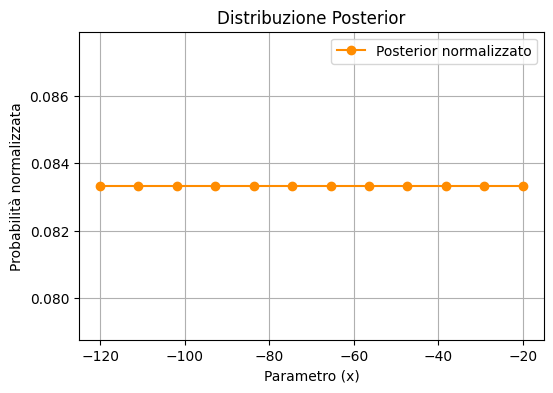

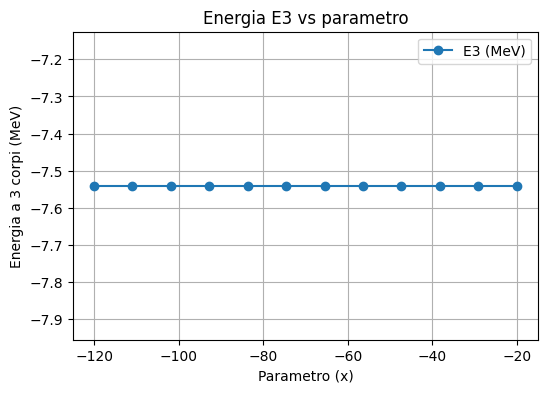

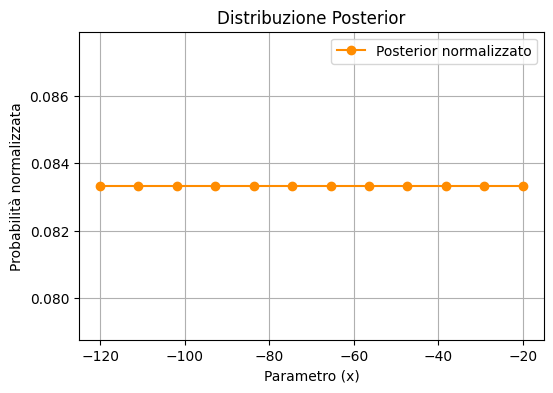

In [34]:
%matplotlib inline
import matplotlib
print("backend:", matplotlib.get_backend())
# deve stampare 'module://matplotlib_inline.backend_inline'

import pandas as pd
import matplotlib.pyplot as plt

# === Parametri ===
csv_file = "sweep_v01.csv"   # il file che hai già generato con bayes_trimod
fig_dir = "figs"

# === Lettura dati ===
df = pd.read_csv(csv_file)
print(f"Letti {len(df)} punti da {csv_file}")
print(df.head())

# === Plot 1: Energia E3 vs parametro ===
plt.figure(figsize=(6, 4))
plt.plot(df["x"], df["E3"], "o-", label="E3 (MeV)")
plt.xlabel("Parametro (x)")
plt.ylabel("Energia a 3 corpi (MeV)")
plt.title("Energia E3 vs parametro")
plt.grid(True)
plt.legend()
plt.show()

# === Plot 2: Posterior normalizzato ===
plt.figure(figsize=(6, 4))
plt.plot(df["x"], df["post_norm"], "o-", color="darkorange", label="Posterior normalizzato")
plt.xlabel("Parametro (x)")
plt.ylabel("Probabilità normalizzata")
plt.title("Distribuzione Posterior")
plt.grid(True)
plt.legend()
plt.show()
